In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# PART 1 - Dataset Preparation
class CattleDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_filename = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert("RGB")

        # Fetch bounding boxes and class label
        boxes = self.annotations.iloc[idx, 4:8].values.astype(float)
        label = self.annotations.iloc[idx, 3]  # The class label

        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(self.get_class_id(label), dtype=torch.long)
        return image, boxes, label_tensor

    def get_class_id(self, class_name):
        class_map = {
            'Infected_Foot_Image': 0,
            'Mouth Disease Infected': 1,
            'Normal_Healthy_Cow': 2,
            'Normal_Mouth_Image': 3,
            'lumpy skin': 4
        }
        return class_map.get(class_name, -1)

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
# Function to create DataLoader
def get_data_loader(annotations_file, img_dir, batch_size=32, shuffle=True, transform=None):
    dataset = CattleDataset(annotations_file, img_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [4]:
# PART 2 - Hybrid Model Definition
class HybridYOLOEfficientNet(torch.nn.Module):
    def __init__(self, yolo_model, efficientnet_model):
        super(HybridYOLOEfficientNet, self).__init__()
        self.yolo_model = yolo_model.model
        self.efficientnet = efficientnet_model.features
        
        # Dynamically find the size of the feature output from EfficientNet
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features_size = self.efficientnet(dummy_input).view(1, -1).size(1)

        self.fc = torch.nn.Linear(features_size, 256)
        self.output = torch.nn.Linear(256, 5)

    def forward(self, x):
        detection_results = self.yolo_model(x)
        features = self.efficientnet(x)
        features = torch.flatten(features, 1)
        features = torch.relu(self.fc(features))
        class_outputs = self.output(features)
        return class_outputs, detection_results

In [5]:
def train_model(model, data_loader, criterion, optimizer, device, epochs=10):
    model.train()
    training_loss = []
    training_accuracy = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0
        all_labels = []
        all_preds = []

        for inputs, _, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Calculate metrics
        epoch_loss = running_loss / len(data_loader)
        epoch_acc = correct_preds / total_samples
        training_loss.append(epoch_loss)
        training_accuracy.append(epoch_acc)

        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return training_loss, training_accuracy

In [6]:
# PART 4 - Plotting Training Metrics
def plot_metrics(training_loss, training_accuracy):
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label="Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy over Epochs")
    plt.legend()

    plt.show()

Using device: cpu
Epoch [1/1] - Loss: 0.8350, Accuracy: 0.7001
Precision: 0.4894, Recall: 0.3310, F1 Score: 0.3485


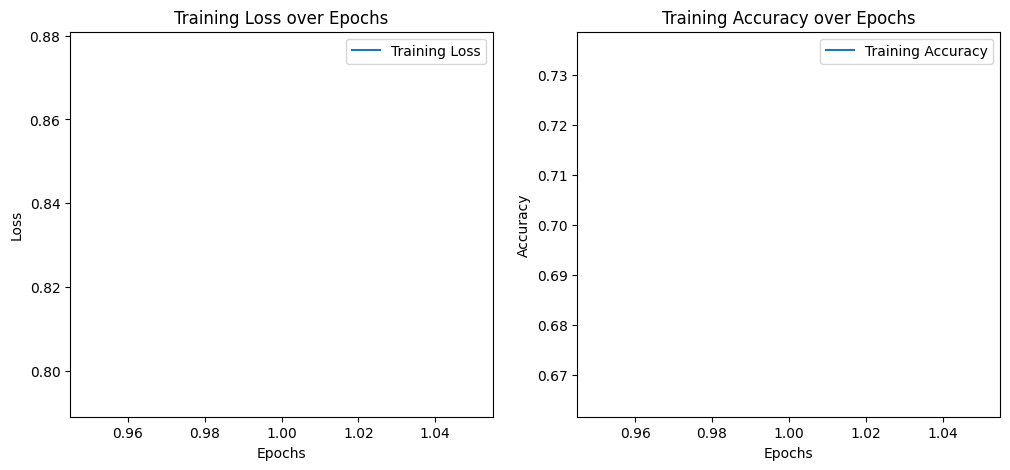

In [ ]:
# PART 5 - Main Function
if __name__ == "__main__":
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load pretrained YOLO and EfficientNet models
    yolo_model = YOLO("yolo11n.pt")
    efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Initialize the hybrid model
    hybrid_model = HybridYOLOEfficientNet(yolo_model, efficientnet_model).to(device)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.001)

    # Create DataLoader
    train_loader = get_data_loader('train/_annotations.csv', 'train', batch_size=32, transform=transform)

    # Train the model and capture metrics
    training_loss, training_accuracy = train_model(hybrid_model, train_loader, criterion, optimizer, device, epochs=10)

    # Plot the training metrics
    plot_metrics(training_loss, training_accuracy)